# *Discerning Haggis* 2016-ml-contest submission

**Author:** [Carlos Alberto da Costa Filho](http://www.researchgate.net/profile/Carlos_Da_Costa_Filho), University of Edinburgh

![UoE](https://www.eusa.ed.ac.uk/asset/Organisation/16256/School%20Pages%20GeoSciences.jpg?thumbnail_width=1140&thumbnail_height=150&resize_type=ResizeFitAll)


## Load libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style='whitegrid',
        rc={'lines.linewidth': 2.5,
            'figure.figsize': (10, 8),
            'text.usetex': False,
            # 'font.family': 'sans-serif',
            # 'font.sans-serif': 'Optima LT Std',
        })

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm

## Convenience functions

In [2]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc


adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


## Load, treat and color data

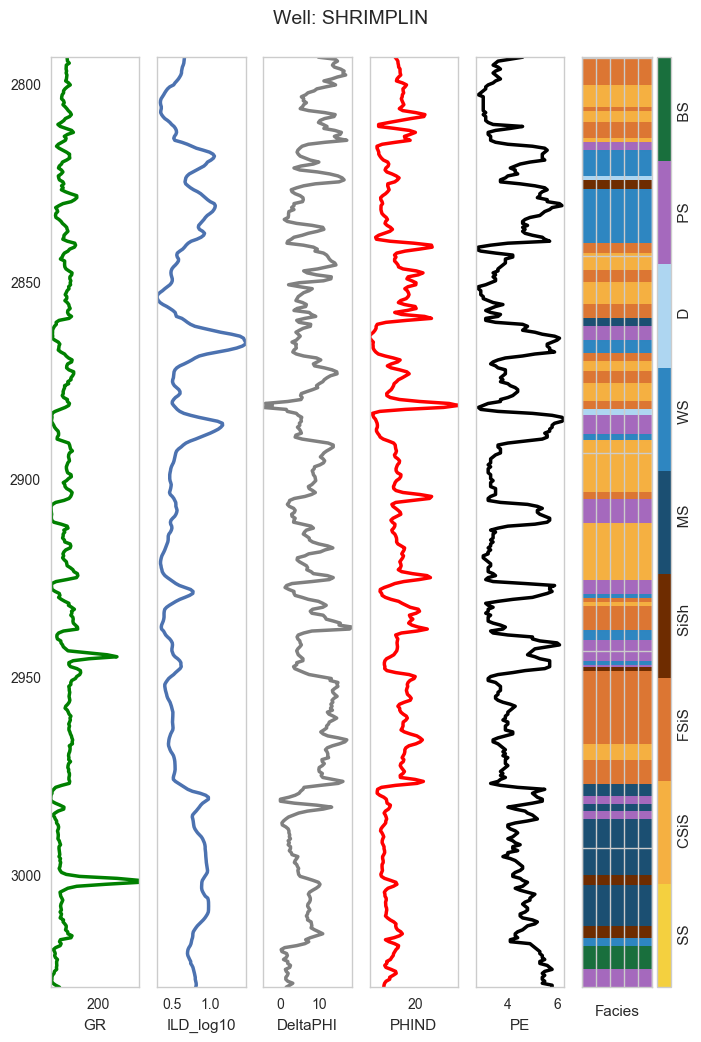

In [3]:
# Loading Data
validationFull = pd.read_csv('../validation_data_nofacies.csv')
training_data = pd.read_csv('../facies_vectors.csv')

# Treat Data
training_data.fillna(training_data.mean(),inplace=True)
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()
training_data.describe()

# Color Data
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

## Condition dataset


In [4]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

## Test, train and cross-validate
Up to here, there have been no secrets, just reusing the standard code to load the data. Now, instead of doing the usual test/train split, I create another dataset, the cross-validate set. The split will be 60% train, 20% cross-validate and 20% test.
It which will be used as the "test set", to tune the neural network parameters. My actual test set will only be used to predict the performance of my neural network at the end.

In [5]:
X_train, X_cv_test, y_train, y_cv_test = train_test_split(scaled_features,
        correct_facies_labels, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_cv_test, y_cv_test,
        test_size=0.5, random_state=42)

## Tuning
### Selecting model size
I create a number of model sizes, all with 3 hidden layers. The first and largest hidden layer is normally distributed between 1 to 500 nodes. The second ranges from 1 to the number of first nodes. The third ranges from 1 to the number of second nodes.

These different sizes will be used to train several unregularized networks.

In [6]:
lower, upper = 1, 500
mu, sigma = (upper-lower)/2, (upper-lower)/2 
sizes_rv = truncnorm((lower - mu) / sigma, (upper - mu) / sigma,
        loc=mu, scale=sigma)
samples = 30
sizes_L1 = [ int(d) for d in sizes_rv.rvs(samples) ]
sizes_L2 = []
sizes_L3 = []
for sL1 in sizes_L1:
    lower, upper = 1, sL1+1
    mu, sigma = (upper-lower)/2+1, (upper-lower)/2+1
    sizes_rv = truncnorm((lower - mu) / sigma, (upper - mu) / sigma,
            loc=mu, scale=sigma)
    sL2 = int(sizes_rv.rvs(1)[0])
    sizes_L2.append(sL2)

    lower, upper = 1, sL2+1
    mu, sigma = (upper-lower)/2+1, (upper-lower)/2+1
    sizes_rv = truncnorm((lower - mu) / sigma, (upper - mu) / sigma,
            loc=mu, scale=sigma)
    sL3 = int(sizes_rv.rvs(1)[0])
    sizes_L3.append(sL3)
sizes = sorted(set(zip(sizes_L1, sizes_L2, sizes_L3)),
        key=lambda s: sum(s))


#### Training with several model sizes
This takes a few minutes.

In [7]:
train_error = np.array([])
cv_error = np.array([])
train_adj_error = np.array([])
cv_adj_error = np.array([])
minerr = 1
for i, s in enumerate(sizes):
    clf = MLPClassifier(solver='lbfgs', alpha=0,
                        hidden_layer_sizes=s)
    clf.fit(X_train,y_train)

    # Compute errors
    conf_cv = confusion_matrix(y_cv, clf.predict(X_cv))
    conf_tr = confusion_matrix(y_train, clf.predict(X_train))

    train_error = np.append(train_error, 1-accuracy(conf_tr))
    cv_error = np.append(cv_error, 1-accuracy(conf_cv))

    train_adj_error = np.append(train_adj_error,
            1-accuracy_adjacent(conf_tr, adjacent_facies))
    cv_adj_error = np.append(cv_adj_error,
            1-accuracy_adjacent(conf_cv, adjacent_facies))
    print('[ %3d%% done ] ' % (100*(i+1)/len(sizes),), end="")
    if cv_error[-1] < minerr:
        minerr = cv_error[-1]
        print('CV error = %d%% with' % (100*minerr,), s)
    else:
        print()


[   3% done ] CV error = 43% with (21, 18, 5)
[   6% done ] CV error = 35% with (75, 14, 9)
[  10% done ] 
[  13% done ] CV error = 34% with (112, 43, 25)
[  16% done ] CV error = 31% with (127, 74, 22)
[  20% done ] CV error = 29% with (175, 115, 13)
[  23% done ] 
[  26% done ] 
[  30% done ] 
[  33% done ] 
[  36% done ] 
[  40% done ] 
[  43% done ] 
[  46% done ] 
[  50% done ] 
[  53% done ] 
[  56% done ] 
[  60% done ] 
[  63% done ] 
[  66% done ] 
[  70% done ] 
[  73% done ] 
[  76% done ] 
[  80% done ] 
[  83% done ] 
[  86% done ] 
[  90% done ] 
[  93% done ] 
[  96% done ] 
[ 100% done ] 


#### Plot performance of neural networks vs sum of nodes

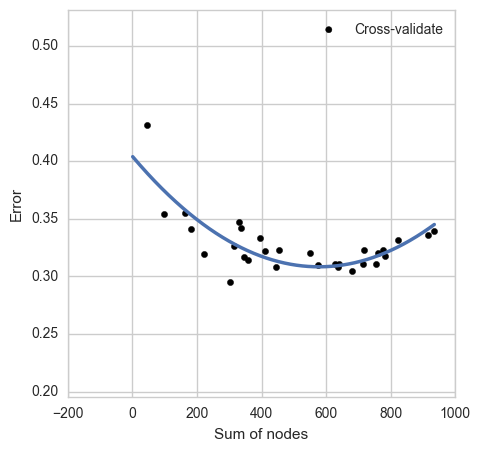

In [8]:
sizes_sum = [ np.sum(s) for s in sizes ]
p = np.poly1d(np.polyfit(sizes_sum, cv_error, 2))
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(sizes_sum, cv_error, c='k', label='Cross-validate')
ax.plot(range(1, max(sizes_sum)+1), p(range(1, max(sizes_sum)+1)))
ax.set_ylim([min(cv_error)-.1, max(cv_error)+.1])
ax.set_xlabel('Sum of nodes')
ax.set_ylabel('Error')
plt.legend()

#### Choose best size from parabolic fit
When I create neural network sizes, the first parameter $n_1$ normally distributed between 1 and 500. Its mean is ~250. The number of nodes in the second layer, $n_2$ depends on the first: it is between 1 and $n_1+1$. Also, its mean is $n_1/2$. The third layer is analogous: between 1 and $n_2/+1$ and with mean $n_2/2$. This is an empirical relationship I use to loosely "parametrize" the number of nodes in each hidden layer.

Knowing the optimal sum, I simply choose the number of nodes whose means would result in this sum, according to my empirical relationships. This gives the following optimal size:

In [9]:
minsum = range(1, max(sizes_sum)+1)[np.argmin(p(range(1, max(sizes_sum)+1)))]
minsize = (int(minsum*4/7),int(minsum*2/7),int(minsum*1/7))
print(minsize)

(330, 165, 82)


### Choose regularization valus
Here we will choose the regularization value using the same approach as before. This takes a few minutes.

In [10]:
alphas = np.append([0], np.sqrt(10)**np.arange(-10, 4.0, 1))
train_error = np.array([])
cv_error = np.array([])
train_adj_error = np.array([])
cv_adj_error = np.array([])
minerr = 1
for i, a in enumerate(alphas):
    clf = MLPClassifier(solver='lbfgs', alpha=a,
                        hidden_layer_sizes=minsize)
    clf.fit(X_train,y_train)

    # Compute errors
    conf_cv = confusion_matrix(y_cv, clf.predict(X_cv))
    conf_tr = confusion_matrix(y_train, clf.predict(X_train))

    train_error = np.append(train_error, 1-accuracy(conf_tr))
    cv_error = np.append(cv_error, 1-accuracy(conf_cv))

    train_adj_error = np.append(train_adj_error,
            1-accuracy_adjacent(conf_tr, adjacent_facies))
    cv_adj_error = np.append(cv_adj_error,
            1-accuracy_adjacent(conf_cv, adjacent_facies))
    print('[ %3d%% done ] ' % (100*(i+1)/len(alphas),), end="")
    if cv_error[-1] < minerr:
        minerr = cv_error[-1]
        print('CV error = %d%% with %g' % (100*minerr, a))
    else:
        print()


[   6% done ] CV error = 32% with 0
[  13% done ] 
[  20% done ] CV error = 32% with 3.16228e-05
[  26% done ] CV error = 31% with 0.0001
[  33% done ] CV error = 31% with 0.000316228
[  40% done ] 
[  46% done ] CV error = 31% with 0.00316228
[  53% done ] 
[  60% done ] CV error = 30% with 0.0316228
[  66% done ] 
[  73% done ] 
[  80% done ] 
[  86% done ] 
[  93% done ] 
[ 100% done ] 


#### Plot performance of neural networks vs regularization

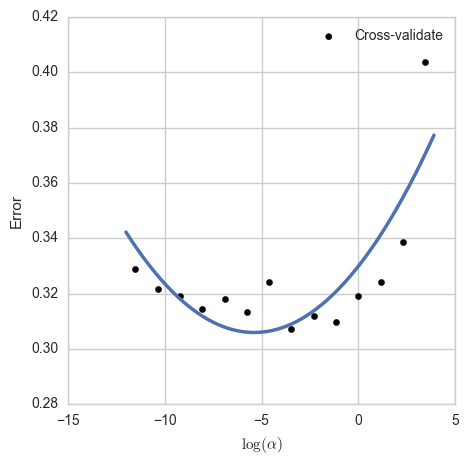

In [11]:
p = np.poly1d(np.polyfit(np.log(alphas[1:]), cv_error[1:], 2))
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(np.log(alphas[1:]), cv_error[1:], c='k', label='Cross-validate')
ax.plot(np.arange(-12, 4.0, .1), p(np.arange(-12, 4.0, .1)))
ax.set_xlabel(r'$\log(\alpha)$')
ax.set_ylabel('Error')
plt.legend()

#### Choose best regularization parameter from parabolic fit


In [12]:
minalpha = np.arange(-12, 4.0, .1)[np.argmin(p(np.arange(-12, 4.0, .1)))]
# minalpha = np.log(alphas)[np.argmin(cv_error)] # This chooses the minimum

minalpha = np.sqrt(10)**minalpha
print(minalpha)

0.00199526231497


## Predict accuracy

Now I train a neural network with the obtained values and predict its accuracy using the test set.

In [13]:
clf = MLPClassifier(solver='lbfgs', alpha=minalpha,
                    hidden_layer_sizes=minsize)
clf.fit(X_train,y_train)
conf_te = confusion_matrix(y_test, clf.predict(X_test))
print('Predicted accuracy %.d%%' % (100*accuracy(conf_te),))

Predicted accuracy 66%


## Save neural network parameters

In [14]:
pd.DataFrame({'alpha':minalpha, 'layer1': minsize[0], 'layer2': minsize[1],
    'layer3': minsize[2]}, index=[0]).to_csv('DHparams.csv')

## Retrain and predict
Finally we train a neural network using *all* data available, and apply it to our blind test.

In [15]:
clf_final = MLPClassifier(solver='lbfgs', alpha=minalpha,
                        hidden_layer_sizes=minsize)
clf_final.fit(scaled_features,correct_facies_labels)

validation_features = validationFull.drop(['Formation', 'Well Name', 'Depth'], axis=1)
scaled_validation = scaler.transform(validation_features)
validation_output = clf_final.predict(scaled_validation)
validationFull['Facies']=validation_output
validationFull.to_csv('well_data_with_facies_DH.csv')

## Final remarks
The workflow used here was as follows: 
    
0) Split dataset into: train (60%), cross-validate (20%) and test (20%)
1) Train unregularized 3-hidden-layers networks using a variety of node sizes
2) Choose size which minimizes cross-validate error
3) Train 3-hidden-layers networks with several regularizations
4) Choose regularization which minimizes cross-validate error
5) Predict accuracy with test set
6) Train a neural network with optimal parameters using all data (train, cross-validate and test)
7) Use this neural network to predict validation dataset

In (1), I decided to choose rather ad-hoc number of hidden layers (3) and an node sizes ratios (4-2-1). I am sure there are better ways to do this, but it was an ideas I was wanting to test.

In (2) I could have plotted the number of degrees of freedom ($n_1 n_2 n_3$) instead of $n_1 + n_2 + n_3$, but the latter gave me more reasonable results. The parabolic fit using the sum was decent, giving me confidence in this choice.

The regularizations in (4) were fairly noisy, but gave an OK result in the end. I was expecting a larger regularization parameter.

The prediction in (5) of **66%** is decent for a first try and is putting me at first place at the moment (wish me luck!).

Overall, I would say this problem has a high variance and can benefit from some new data, as regularizing does not seem to improve very much.
